In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [21]:
!pip install mss pydirectinput pytesseract

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
import time
from matplotlib import pyplot as plt
from gym import Env
from gym.spaces import Box, Discrete
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import os

In [2]:
pytesseract.pytesseract.tesseract_cmd = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

In [3]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 115}
        
    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
            time.sleep(0.05)  # Reduce the delay between actions for faster learning

        done, _ = self.get_done() 
        observation = self.get_observation()
        reward = self.compute_reward(done)
        info = {}
        return observation, reward, done, info
        
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        return resized
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        done_strings = ['GAME', 'GAHE']
        res = pytesseract.image_to_string(done_cap)[:4]
        done = res in done_strings
        return done, done_cap
    
    def compute_reward(self, done):
        if done:
            return -1  # Penalize the agent if the game is over
        else:
            return 0.1  # Provide a small positive reward for each step

In [4]:
env = WebGame()

In [5]:
obs=env.get_observation()

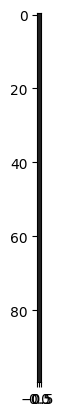

In [6]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [7]:
done,done_cap = env.get_done()

In [8]:
done

True

In [40]:
res

NameError: name 'res' is not defined

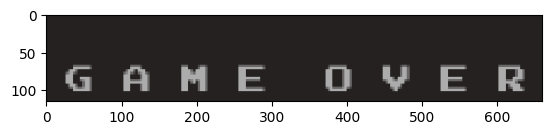

In [9]:
plt.imshow(done_cap)

In [10]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [77]:
env.render()

In [51]:
env.close()

In [54]:
env.reset()

array([[[33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        ...,
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33]]], dtype=uint8)

In [11]:
pydirectinput.FAILSAFE = False

In [184]:
for episode in range(10):
    obs = env.reset()
    done=False
    total_reward = 0
    
    while not done:
        obs,reward,done,info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode{episode} is {total_reward}')

Total Reward for episode0 is 22
Total Reward for episode1 is 15
Total Reward for episode2 is 13
Total Reward for episode3 is 17
Total Reward for episode4 is 16
Total Reward for episode5 is 13
Total Reward for episode6 is 29
Total Reward for episode7 is 10
Total Reward for episode8 is 14
Total Reward for episode9 is 12


In [12]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [13]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.num_timesteps}')
            self.model.save(model_path)

        return True


In [14]:
CHECKPOINT_DIR = 'E:/train2/'
LOG_DIR = 'E:/logs2/'

In [15]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)  # Reduce checkpoint frequency for faster training

In [16]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [17]:
model = DQN('MlpPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=50000, 
            learning_starts=100, exploration_fraction=0.2, target_update_interval=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


D:\Anaconda\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [19]:
model.learn(total_timesteps=100000, callback=callback)

Logging to E:/logs1/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 0.15     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 30       |
|    total_timesteps  | 50       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 0.0875   |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 59       |
|    total_timesteps  | 95       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 0.075    |
|    exploration_rate | 0.993    |
| time/               |      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 0.101    |
|    exploration_rate | 0.959    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 1        |
|    time_elapsed     | 516      |
|    total_timesteps  | 865      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0837   |
|    n_updates        | 191      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 0.0987   |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 1        |
|    time_elapsed     | 544      |
|    total_timesteps  | 911      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.207    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 0.094    |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1        |
|    time_elapsed     | 982      |
|    total_timesteps  | 1623     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates        | 380      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 0.1      |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 1        |
|    time_elapsed     | 1012     |
|    total_timesteps  | 1673     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.1     |
|    ep_rew_mean      | 0.113    |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1        |
|    time_elapsed     | 1448     |
|    total_timesteps  | 2394     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 573      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.1     |
|    ep_rew_mean      | 0.105    |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 1        |
|    time_elapsed     | 1476     |
|    total_timesteps  | 2437     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.174    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.2     |
|    ep_rew_mean      | 0.123    |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 1        |
|    time_elapsed     | 1917     |
|    total_timesteps  | 3188     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 771      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.3     |
|    ep_rew_mean      | 0.134    |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 1        |
|    time_elapsed     | 1949     |
|    total_timesteps  | 3241     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0484   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.1     |
|    ep_rew_mean      | 0.105    |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 1        |
|    time_elapsed     | 2376     |
|    total_timesteps  | 3946     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.149    |
|    n_updates        | 961      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 0.101    |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 1        |
|    time_elapsed     | 2404     |
|    total_timesteps  | 3990     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 0.077    |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 1        |
|    time_elapsed     | 2845     |
|    total_timesteps  | 4706     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 1151     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 0.084    |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 1        |
|    time_elapsed     | 2874     |
|    total_timesteps  | 4758     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0655   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.4     |
|    ep_rew_mean      | 0.136    |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 456      |
|    fps              | 1        |
|    time_elapsed     | 3328     |
|    total_timesteps  | 5520     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 1354     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 0.147    |
|    exploration_rate | 0.735    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1        |
|    time_elapsed     | 3358     |
|    total_timesteps  | 5573     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.323    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 0.159    |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1        |
|    time_elapsed     | 3816     |
|    total_timesteps  | 6333     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 1558     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 0.166    |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 524      |
|    fps              | 1        |
|    time_elapsed     | 3845     |
|    total_timesteps  | 6384     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 0.167    |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 584      |
|    fps              | 1        |
|    time_elapsed     | 4293     |
|    total_timesteps  | 7133     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.145    |
|    n_updates        | 1758     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 0.165    |
|    exploration_rate | 0.659    |
| time/               |          |
|    episodes         | 588      |
|    fps              | 1        |
|    time_elapsed     | 4324     |
|    total_timesteps  | 7183     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 0.157    |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 648      |
|    fps              | 1        |
|    time_elapsed     | 4765     |
|    total_timesteps  | 7924     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.312    |
|    n_updates        | 1955     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 0.159    |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 652      |
|    fps              | 1        |
|    time_elapsed     | 4797     |
|    total_timesteps  | 7975     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 0.156    |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 1        |
|    time_elapsed     | 5246     |
|    total_timesteps  | 8730     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 2157     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 0.151    |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 716      |
|    fps              | 1        |
|    time_elapsed     | 5276     |
|    total_timesteps  | 8777     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 0.149    |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 776      |
|    fps              | 1        |
|    time_elapsed     | 5725     |
|    total_timesteps  | 9527     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 2356     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 0.149    |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 1        |
|    time_elapsed     | 5753     |
|    total_timesteps  | 9575     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.213    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 0.17     |
|    exploration_rate | 0.508    |
| time/               |          |
|    episodes         | 840      |
|    fps              | 1        |
|    time_elapsed     | 6212     |
|    total_timesteps  | 10349    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 2562     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 0.168    |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 844      |
|    fps              | 1        |
|    time_elapsed     | 6239     |
|    total_timesteps  | 10396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 0.212    |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 904      |
|    fps              | 1        |
|    time_elapsed     | 6716     |
|    total_timesteps  | 11199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 2774     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 0.211    |
|    exploration_rate | 0.466    |
| time/               |          |
|    episodes         | 908      |
|    fps              | 1        |
|    time_elapsed     | 6746     |
|    total_timesteps  | 11249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 0.252    |
|    exploration_rate | 0.427    |
| time/               |          |
|    episodes         | 968      |
|    fps              | 1        |
|    time_elapsed     | 7231     |
|    total_timesteps  | 12062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 2990     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 0.254    |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 1        |
|    time_elapsed     | 7263     |
|    total_timesteps  | 12119    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.171    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 0.231    |
|    exploration_rate | 0.386    |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 1        |
|    time_elapsed     | 7741     |
|    total_timesteps  | 12921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.192    |
|    n_updates        | 3205     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 0.227    |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 1        |
|    time_elapsed     | 7771     |
|    total_timesteps  | 12973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 0.242    |
|    exploration_rate | 0.346    |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 1        |
|    time_elapsed     | 8259     |
|    total_timesteps  | 13777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 3419     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 0.238    |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 1        |
|    time_elapsed     | 8288     |
|    total_timesteps  | 13829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0887   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 0.252    |
|    exploration_rate | 0.304    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 1        |
|    time_elapsed     | 8780     |
|    total_timesteps  | 14651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 3637     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 0.28     |
|    exploration_rate | 0.3      |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 1        |
|    time_elapsed     | 8823     |
|    total_timesteps  | 14729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 0.34     |
|    exploration_rate | 0.259    |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 1        |
|    time_elapsed     | 9330     |
|    total_timesteps  | 15602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.339    |
|    n_updates        | 3875     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 0.349    |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 1        |
|    time_elapsed     | 9364     |
|    total_timesteps  | 15658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 0.31     |
|    exploration_rate | 0.217    |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 1        |
|    time_elapsed     | 9855     |
|    total_timesteps  | 16481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 4095     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 0.307    |
|    exploration_rate | 0.215    |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 1        |
|    time_elapsed     | 9885     |
|    total_timesteps  | 16532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.166    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.8     |
|    ep_rew_mean      | 0.383    |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 1        |
|    time_elapsed     | 10438    |
|    total_timesteps  | 17478    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 4344     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.9     |
|    ep_rew_mean      | 0.391    |
|    exploration_rate | 0.167    |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 1        |
|    time_elapsed     | 10475    |
|    total_timesteps  | 17543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 0.397    |
|    exploration_rate | 0.126    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 1        |
|    time_elapsed     | 10981    |
|    total_timesteps  | 18401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 4575     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 0.396    |
|    exploration_rate | 0.123    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 1        |
|    time_elapsed     | 11017    |
|    total_timesteps  | 18458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.242    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 0.426    |
|    exploration_rate | 0.0778   |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 1        |
|    time_elapsed     | 11572    |
|    total_timesteps  | 19414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0651   |
|    n_updates        | 4828     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.4     |
|    ep_rew_mean      | 0.439    |
|    exploration_rate | 0.0747   |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 1        |
|    time_elapsed     | 11609    |
|    total_timesteps  | 19481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0919   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.1     |
|    ep_rew_mean      | 0.514    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 1        |
|    time_elapsed     | 12170    |
|    total_timesteps  | 20433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 5083     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 0.518    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 1        |
|    time_elapsed     | 12213    |
|    total_timesteps  | 20514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.479    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 1        |
|    time_elapsed     | 12754    |
|    total_timesteps  | 21446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 5336     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.481    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 1        |
|    time_elapsed     | 12789    |
|    total_timesteps  | 21498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.302    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.476    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 1        |
|    time_elapsed     | 13335    |
|    total_timesteps  | 22434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 5583     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.483    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 1        |
|    time_elapsed     | 13372    |
|    total_timesteps  | 22505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.4     |
|    ep_rew_mean      | 0.442    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 1        |
|    time_elapsed     | 13915    |
|    total_timesteps  | 23417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 5829     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.4     |
|    ep_rew_mean      | 0.436    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 1        |
|    time_elapsed     | 13947    |
|    total_timesteps  | 23469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0481   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 0.428    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 1        |
|    time_elapsed     | 14483    |
|    total_timesteps  | 24400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 6074     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.456    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 1        |
|    time_elapsed     | 14523    |
|    total_timesteps  | 24479    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.7     |
|    ep_rew_mean      | 0.473    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 1        |
|    time_elapsed     | 15070    |
|    total_timesteps  | 25426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.244    |
|    n_updates        | 6331     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 0.487    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 1        |
|    time_elapsed     | 15113    |
|    total_timesteps  | 25502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.1      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 0.486    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 1        |
|    time_elapsed     | 15660    |
|    total_timesteps  | 26437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 6584     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 0.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 1        |
|    time_elapsed     | 15696    |
|    total_timesteps  | 26500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 0.517    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 1        |
|    time_elapsed     | 16271    |
|    total_timesteps  | 27478    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 6844     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 0.503    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 1        |
|    time_elapsed     | 16300    |
|    total_timesteps  | 27527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.8     |
|    ep_rew_mean      | 0.381    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 1        |
|    time_elapsed     | 16816    |
|    total_timesteps  | 28383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 7070     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.9     |
|    ep_rew_mean      | 0.394    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 1        |
|    time_elapsed     | 16860    |
|    total_timesteps  | 28458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 0.414    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 1        |
|    time_elapsed     | 17401    |
|    total_timesteps  | 29386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 7321     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.1     |
|    ep_rew_mean      | 0.408    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 1        |
|    time_elapsed     | 17438    |
|    total_timesteps  | 29441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 0.434    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 1        |
|    time_elapsed     | 17983    |
|    total_timesteps  | 30372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 7567     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.3     |
|    ep_rew_mean      | 0.428    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 1        |
|    time_elapsed     | 18018    |
|    total_timesteps  | 30430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.463    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 1        |
|    time_elapsed     | 18559    |
|    total_timesteps  | 31378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.401    |
|    n_updates        | 7819     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.479    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 1        |
|    time_elapsed     | 18601    |
|    total_timesteps  | 31452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.1     |
|    ep_rew_mean      | 0.512    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 1        |
|    time_elapsed     | 19156    |
|    total_timesteps  | 32430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 8082     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.1     |
|    ep_rew_mean      | 0.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 1        |
|    time_elapsed     | 19188    |
|    total_timesteps  | 32484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 0.563    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 1        |
|    time_elapsed     | 19752    |
|    total_timesteps  | 33497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 8349     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.5     |
|    ep_rew_mean      | 0.546    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 1        |
|    time_elapsed     | 19785    |
|    total_timesteps  | 33550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 0.556    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 1        |
|    time_elapsed     | 20346    |
|    total_timesteps  | 34505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 8601     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 0.539    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 1        |
|    time_elapsed     | 20376    |
|    total_timesteps  | 34556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.457    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 1        |
|    time_elapsed     | 20940    |
|    total_timesteps  | 35505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 8851     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.455    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 1        |
|    time_elapsed     | 20977    |
|    total_timesteps  | 35565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 0.525    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 1        |
|    time_elapsed     | 21549    |
|    total_timesteps  | 36562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 9115     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 0.544    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2572     |
|    fps              | 1        |
|    time_elapsed     | 21596    |
|    total_timesteps  | 36650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 0.538    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 1        |
|    time_elapsed     | 22161    |
|    total_timesteps  | 37611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.519    |
|    n_updates        | 9377     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 0.544    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2636     |
|    fps              | 1        |
|    time_elapsed     | 22198    |
|    total_timesteps  | 37676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 0.517    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 1        |
|    time_elapsed     | 22765    |
|    total_timesteps  | 38643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 9635     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 0.498    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 1        |
|    time_elapsed     | 22802    |
|    total_timesteps  | 38704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0695   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 0.479    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 1        |
|    time_elapsed     | 23356    |
|    total_timesteps  | 39653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 9888     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 0.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2764     |
|    fps              | 1        |
|    time_elapsed     | 23399    |
|    total_timesteps  | 39733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.6     |
|    ep_rew_mean      | 0.561    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 1        |
|    time_elapsed     | 23980    |
|    total_timesteps  | 40756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.346    |
|    n_updates        | 10163    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.4     |
|    ep_rew_mean      | 0.538    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 1        |
|    time_elapsed     | 24012    |
|    total_timesteps  | 40812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0701   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.458    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 1        |
|    time_elapsed     | 24541    |
|    total_timesteps  | 41687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0497   |
|    n_updates        | 10396    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 0.464    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2892     |
|    fps              | 1        |
|    time_elapsed     | 24590    |
|    total_timesteps  | 41777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates      

KeyboardInterrupt: 

In [16]:
model.load('E:/train1/best_model_42000') 

NameError: name 'model' is not defined

In [1]:
for episode in range(50): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
#         time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
#     time.sleep(2)

NameError: name 'env' is not defined

D:\Anaconda\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total Reward for episode 0 is 0.6000000000000003
Total Reward for episode 1 is -0.10000000000000009
Total Reward for episode 2 is 0.19999999999999996
Total Reward for episode 3 is -1.1102230246251565e-16
Total Reward for episode 4 is 0.09999999999999987
Total Reward for episode 5 is 0.5000000000000002
Total Reward for episode 6 is 0.19999999999999996
Total Reward for episode 7 is 0.40000000000000013
Total Reward for episode 8 is 0.19999999999999996
Total Reward for episode 9 is -0.20000000000000007
Total Reward for episode 10 is 0.8000000000000005
Total Reward for episode 11 is -0.10000000000000009
Total Reward for episode 12 is 0.7000000000000004
Total Reward for episode 13 is 0.7000000000000004
Total Reward for episode 14 is -0.10000000000000009
Total Reward for episode 15 is -0.10000000000000009
Total Reward for episode 16 is 0.6000000000000003
Total Reward for episode 17 is 0.19999999999999996
Total Reward

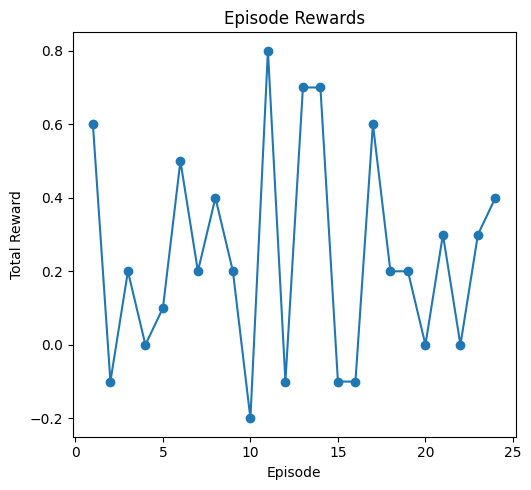

In [18]:
# Load the pre-trained model
model_path = 'E:/train2/best_model_76000'
model = DQN.load(model_path, env=env)

# Test the loaded model
total_episodes = 24
total_reward_sum = 0
successful_episodes = 0
episode_rewards = []

for episode in range(total_episodes): 
    obs = env.reset()
    done = False
    episode_reward = 0
    
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(int(action))
        episode_reward += reward
    
    total_reward_sum += episode_reward
    episode_rewards.append(episode_reward)
    
    if not done:
        successful_episodes += 1
    
    print(f'Total Reward for episode {episode} is {episode_reward}')

# Result Analysis
average_reward_per_episode = total_reward_sum / total_episodes
success_rate = successful_episodes / total_episodes

print(f'\nResult Analysis:')
print(f'Average Reward per Episode: {average_reward_per_episode}')
print(f'Success Rate: {success_rate * 100:.2f}%')

# Plotting
plt.figure(figsize=(10, 5))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(range(1, total_episodes + 1), episode_rewards, marker='o', linestyle='-')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plot success rate
# plt.subplot(1, 2, 2)
# plt.bar(['Success', 'Failure'], [successful_episodes, total_episodes - successful_episodes], color=['green', 'red'])
# plt.title('Success Rate')
# plt.ylabel('Number of Episodes')

plt.tight_layout()
plt.show()
